<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/diffusers/sdxl-compel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Prompt Weighing and Blending using for SDXL 1.0 using [Compel](https://github.com/damian0815/compel) and [🧨 Diffusers](https://huggingface.co/docs/diffusers)


This notebook demonstrates the following:
- Performing text-conditional image-generations using [🧨 Diffusers](https://huggingface.co/docs/diffusers).
- Using the Stable Diffusion XL Refiner pipeline to further refine the outputs of the base model.
- Manage image generation experiments using [Weights & Biases](http://wandb.ai/geekyrakshit).
- Log the prompts and generated images to [Weigts & Biases](http://wandb.ai/geekyrakshit) for visalization.

## Installing the Dependencies

In [1]:
# !pip install -qq diffusers["torch"] transformers compel wandb
# !pip install scipy

In [2]:
import torch
import wandb
from diffusers import DiffusionPipeline, EulerDiscreteScheduler
from compel import Compel, ReturnedEmbeddingsType

## Experiment Management using Weights & Biases

Managing our image generation experiments is crucial for the sake of reproducibility. Hence we sync all the configs of our experiments with our Weights & Biases run. This stores all the configs of the experiments, right from the prompts to the refinement technque and the configuration of the scheduler.

In [3]:
wandb.init(project="stable-diffusion-xl", entity="mratanusarkar", job_type="text-to-image-compel", save_code=True)

config = wandb.config
config.stable_diffusion_checkpoint = "stabilityai/stable-diffusion-xl-base-1.0"
config.refiner_checkpoint = "stabilityai/stable-diffusion-xl-refiner-1.0"
config.offload_to_cpu = False
config.compile_model = False
config.prompt_1 = "a cute furry puppy, soft, cute, bright eyes, full body, zoomed out, stuffed toy, puffy, detailed fur"
config.prompt_2 = "a cute furry puppy, soft, cute, bright eyes, full body, zoomed out, stuffed toy, puffy, detailed fur"
config.negative_prompt_1 = ""
config.negative_prompt_2 = ""
config.seed = 2208198900
config.use_ensemble_of_experts = False
config.num_inference_steps = 100
config.num_refinement_steps = 150
config.high_noise_fraction = 0.8 # Set explicitly only if config.use_ensemble_of_experts is True
config.scheduler_kwargs = {
    "beta_end": 0.012,
    "beta_schedule": "scaled_linear", # one of ["linear", "scaled_linear"]
    "beta_start": 0.00085,
    "interpolation_type": "linear", # one of ["linear", "log_linear"]
    "num_train_timesteps": 1000,
    "prediction_type": "epsilon", # one of ["epsilon", "sample", "v_prediction"]
    "steps_offset": 1,
    "timestep_spacing": "leading", # one of ["linspace", "leading"]
    "trained_betas": None,
    "use_karras_sigmas": False,
}
config.prompt_credits = ""

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mratanusarkar. Use `wandb login --relogin` to force relogin


We can make the experiment deterministic based on the seed specified in the experiment configs.

In [4]:
if config.seed is not None:
    generator = [torch.Generator(device="cuda").manual_seed(config.seed)]
else:
    generator = [torch.Generator(device="cuda")]

## Creating the Diffusion Pipelines

For performing text-conditional image generation, we use the `diffusers` library to define the diffusion pipelines corresponding to the base SDXL model and the SDXL refinement model.

In [5]:
pipe = DiffusionPipeline.from_pretrained(
    config.stable_diffusion_checkpoint,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True,
    scheduler=EulerDiscreteScheduler(**config.scheduler_kwargs),
)

if config.offload_to_cpu:
    pipe.enable_model_cpu_offload()
else:
    pipe.to("cuda")

if config.compile_model:
    pipe.unet = torch.compile(pipe.unet, mode="reduce-overhead", fullgraph=True)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [6]:
if config.prompt_2 == "" and config.negative_prompt_2 == "":
    base_compel = Compel(
        tokenizer=[pipe.tokenizer, pipe.tokenizer_2],
        text_encoder=[pipe.text_encoder, pipe.text_encoder_2],
        returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
        requires_pooled=[False, True]
    )

    base_positive_prompt_embeds, base_positive_prompt_pooled = base_compel(config.prompt)
    base_negative_prompt_embeds, base_negative_prompt_pooled = base_compel(config.negative_prompt)
    base_positive_prompt_embeds, base_negative_prompt_embeds = base_compel.pad_conditioning_tensors_to_same_length([
        base_positive_prompt_embeds, base_negative_prompt_embeds
    ])
else:
    base_compel_1 = Compel(
        tokenizer=pipe.tokenizer,
        text_encoder=pipe.text_encoder,
        returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
        requires_pooled=False,
    )

    base_positive_prompt_embeds_1 = base_compel_1(config.prompt_1)
    base_negative_prompt_embeds_1 = base_compel_1(config.negative_prompt_1)
    
    base_compel_2 = Compel(
        tokenizer=pipe.tokenizer_2,
        text_encoder=pipe.text_encoder_2,
        returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NON_NORMALIZED,
        requires_pooled=True,
    )

    base_positive_prompt_embeds_2, base_positive_prompt_pooled = base_compel_2(config.prompt_2)
    base_negative_prompt_embeds_2, base_negative_prompt_pooled = base_compel_2(config.negative_prompt_2)
    
    (
        base_positive_prompt_embeds_2, base_negative_prompt_embeds_2
    ) = base_compel_2.pad_conditioning_tensors_to_same_length([
        base_positive_prompt_embeds_2, base_negative_prompt_embeds_2
    ])
    
    base_positive_prompt_embeds = torch.cat((base_positive_prompt_embeds_1, base_positive_prompt_embeds_2), dim=-1)
    base_negative_prompt_embeds = torch.cat((base_negative_prompt_embeds_1, base_negative_prompt_embeds_2), dim=-1)
    

## Text-to-Image Generation

Now, we pass the embeddings and pooled prompts to the Stable Diffusion XL pipeline.

In [7]:
image = pipe(
    prompt_embeds=base_positive_prompt_embeds,
    pooled_prompt_embeds=base_positive_prompt_pooled,
    negative_prompt_embeds=base_negative_prompt_embeds,
    negative_pooled_prompt_embeds=base_negative_prompt_pooled,
    output_type="pil",
    num_inference_steps=config.num_inference_steps,
    generator=generator,
).images[0]

  0%|          | 0/100 [00:00<?, ?it/s]

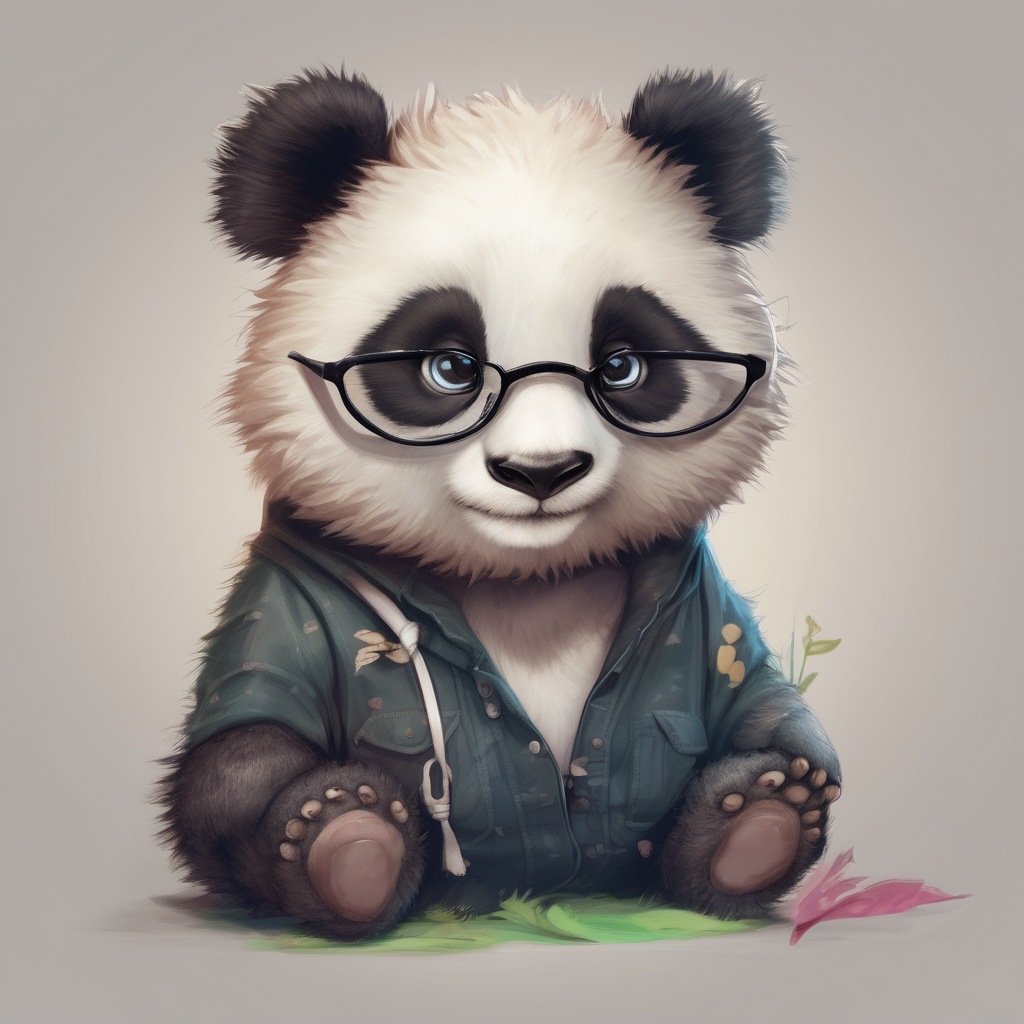

In [8]:
image

## Logging the Images to Weights & Biases

Now, we log the images to Weights & Biases. This enables us to:

- Visualize our generations
- Examine the generated images across different images
- Ensure reproducibility of the experiments

In [9]:
# table = wandb.Table(columns=[
#     "Prompt-1",
#     "Prompt-2",
#     "Negative-Prompt-1",
#     "Negative-Prompt-2",
#     "Generated-Image"
# ])

# image = wandb.Image(image)

# table.add_data(
#     config.prompt_1,
#     config.prompt_2,
#     config.negative_prompt_1,
#     config.negative_prompt_2,
#     image,
# )
# wandb.log({
#     "Generated-Image": image,
#     "Text-to-Image": table
# })
# wandb.finish()